# CMAP-Elites DEMO

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, axis_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions
from pcgsepy.evo.genops import expander

## Setup

In [4]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [5]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [6]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

# for k in block_definitions.keys():
#     if k != "":  # TODO: This is a probable bug, reported to the SE API devs
#         ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

In [7]:
used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

for k in used_ll_blocks:
    ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

In [12]:
expander.initialize(rules=lsystem.hl_solver.parser.rules)

## MAP-Elites

In [13]:
from pcgsepy.evo.fitness import box_filling_fitness, bounding_box_fitness, func_blocks_fitness, axis_fitness

feasible_fitnesses = [bounding_box_fitness,
                      box_filling_fitness,
                      func_blocks_fitness,
                      axis_fitness]

In [14]:
from pcgsepy.mapelites.map import MAPElites

In [15]:
mapelites = MAPElites(lsystem=lsystem,
                      feasible_fitnesses=feasible_fitnesses,
                      behavior_limits=(10, 20),
                      n_bins=(8, 8))

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

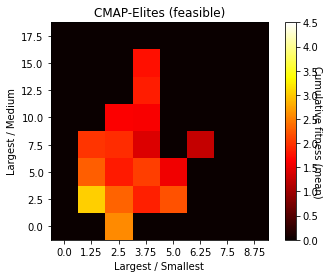

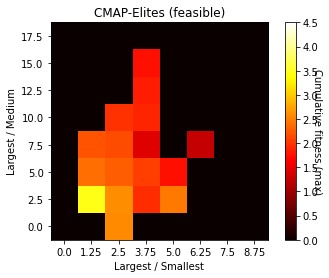

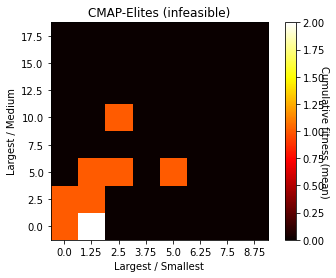

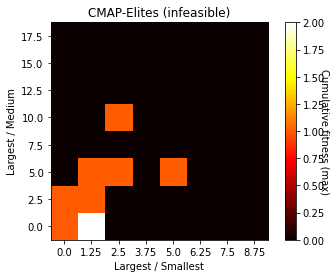

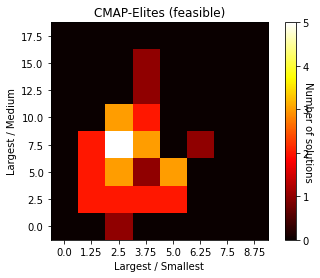

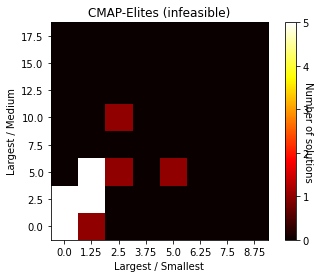

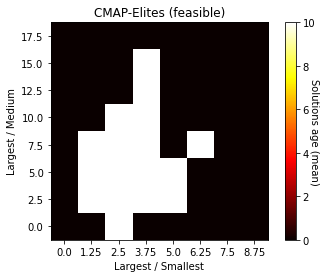

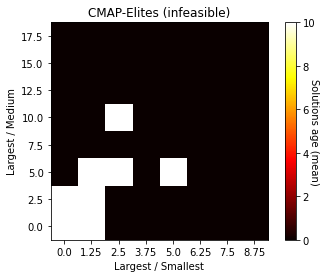

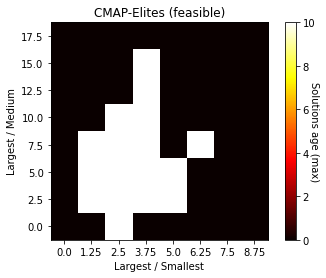

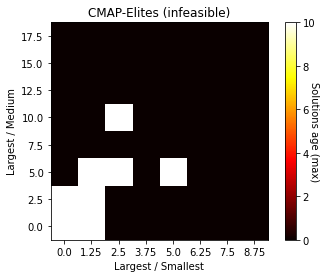

In [17]:
mapelites.generate_initial_populations(pops_size=20,
                                       n_retries=100)

mapelites.show_fitness(show_mean=True,
                       population='feasible')
mapelites.show_fitness(show_mean=False,
                       population='feasible')
mapelites.show_fitness(show_mean=True,
                       population='infeasible')
mapelites.show_fitness(show_mean=False,
                       population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')

  0%|          | 0/2 [00:00<?, ?it/s]

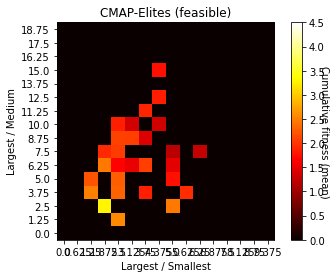

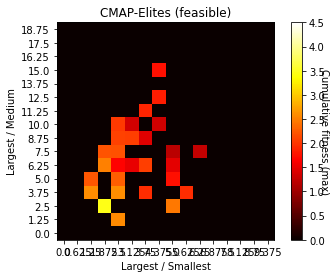

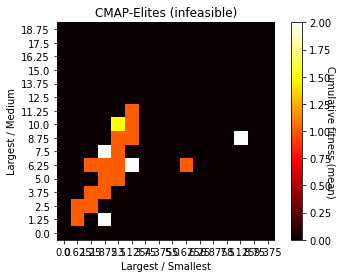

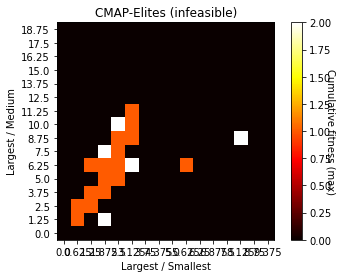

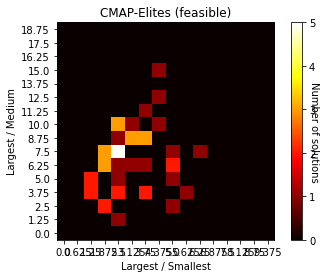

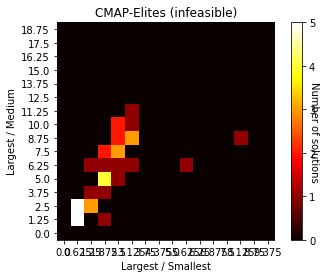

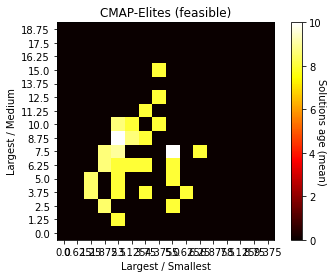

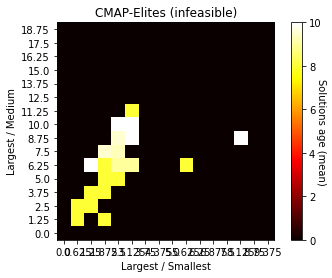

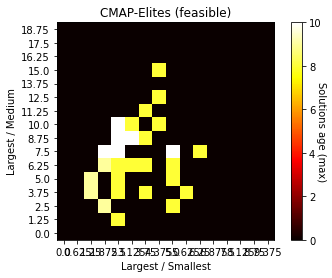

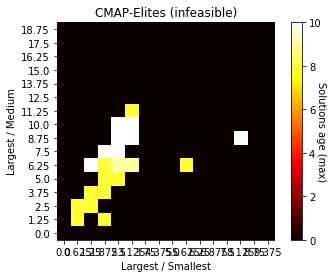

In [18]:
from tqdm.notebook import trange

for i in trange(2):
    mapelites.rand_step(gen=i)

# mapelites.interactive_mode(n_steps=5)

mapelites.show_fitness(show_mean=True,
                       population='feasible')
mapelites.show_fitness(show_mean=False,
                       population='feasible')
mapelites.show_fitness(show_mean=True,
                       population='infeasible')
mapelites.show_fitness(show_mean=False,
                       population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')

## DASH

In [19]:
!pip install dash dash-html-components dash-core-components

In [20]:
!pip install pandas

In [21]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt

from typing import Tuple

In [38]:
app = dash.Dash(__name__)

# disp_map = np.zeros(shape=mapelites.bins.shape)
# for i in range(mapelites.bins.shape[0]):
#     for j in range(mapelites.bins.shape[1]):
#         disp_map[i, j] = mapelites.bins[i, j].get_metric(metric='fitness',
#                                                          use_mean=True,
#                                                          population='feasible')

# x_labels = np.arange(0, mapelites.limits[0], mapelites.bin_sizes[0])
# y_labels = np.arange(0, mapelites.limits[1], mapelites.bin_sizes[1])

# heatmap = px.imshow(disp_map,
#                     zmin=0,
#                     zmax=4.5,
#                     origin='lower',
#                     labels=dict(x="Largest / Medium",
#                                 y="Largest / Smallest",
#                                 color="Fitness"),
#                     x=x_labels,
#                     y=y_labels,
#                     title='Mean feasible population fitness',
#                     aspect='equal',
#                     width=500,
#                     height=500,
#                     color_continuous_scale='Inferno')

# heatmap.update_layout(clickmode='event+select')

styles = {'pre': {'border': 'thin lightgrey solid', 'overflowX': 'scroll'}}


def from_bc_to_idx(bcs: Tuple[int, int], me: MAPElites) -> Tuple[int, int]:
    b0, b1 = bcs
    return (int(b0 // me.bin_sizes[0]), int(b1 // me.bin_sizes[1]))


@app.callback(Output('hidden-element', 'children'),
              Input('heatmap-plot', 'clickData'))
def display_click_data(clickData):
    if clickData is not None:
        i, j = from_bc_to_idx(bcs=(clickData['points'][0]['x'],
                                   clickData['points'][0]['y']),
                              me=mapelites)
        return f'({i}, {j})'
    else:
        return ''


@app.callback(Output('heatmap-plot', 'figure'),
              Input('poplation-dropdown', 'value'),
              Input('metric-dropdown', 'value'),
              Input('method-radio', 'value'))
def update_heatmap(pop_name,
                   metric_name,
                   method_name):
    disp_map = np.zeros(shape=mapelites.bins.shape)
    for i in range(mapelites.bins.shape[0]):
        for j in range(mapelites.bins.shape[1]):
            disp_map[i, j] = mapelites.bins[i, j].get_metric(metric=metric_name,
                                                             use_mean=True if method_name=='mean' else False,
                                                             population=pop_name)
    x_labels = np.arange(0, mapelites.limits[0], mapelites.bin_sizes[0])
    y_labels = np.arange(0, mapelites.limits[1], mapelites.bin_sizes[1])
    heatmap = px.imshow(disp_map,
                        zmin=0,
                        # zmax=4.5,
                        origin='lower',
                        labels=dict(x="Largest / Medium",
                                    y="Largest / Smallest",
                                    color=metric_name),
                        x=x_labels,
                        y=y_labels,
                        # title='Mean feasible population fitness',
                        aspect='equal',
                        width=500,
                        height=500,
                        color_continuous_scale='Inferno')

    heatmap.update_layout(clickmode='event+select')
    return heatmap


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app.layout = html.Div([
    html.P("Fitness landscape:"),
    html.Div([
        dcc.Markdown("""
            ***Choose population:***

            Choose which population to display.
        """),
        dcc.Dropdown(
            ['feasible', 'infeasible'],
            'feasible',
            id='poplation-dropdown',
        ),
        dcc.Markdown("""
            ***Choose metric:***

            Choose which metric to plot.
        """),
        dcc.Dropdown(
            ['fitness', 'age', 'size'],
            'fitness',
            id='metric-dropdown',
        ),
        dcc.Markdown("""
            ***Choose population or elitist:***

            Choose whether to compute the metric for the entire bin population or just the elitist.
        """),
        dcc.RadioItems(
            ['mean', 'max'],
            'mean',
            id='method-radio',
            labelStyle={'display': 'inline-block', 'marginTop': '5px'}
        )]),
    dcc.Graph(id="heatmap-plot"),
    html.Div([
        dcc.Markdown('Selected point is: '),
        html.Div(id='hidden-element')
    ])
])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
